**Previous book**: <a href='./05_normalisation.ipynb'>[Normalisation]</a>

## Part 6: Exploratory Data Analysis
**Note**: This notebook expects <code>tv_database.db</code> from the <code>05_normalisation.ipynb</code> notebook!

In the last stage of the project, we will explore the television data through statistical analysis and visuals. We begin with a broad overview, examining the number of entries, missing values and summary statistics. Next, we will narrow our focus to genres by identifying the ten most common, and comparing the ratings across two platforms, <a href="https://www.imdb.com/">IMDb</a> and <a href="https://www.tvmaze.com/">TVMaze</a>. We will also see how these ratings vary between genres.

In the next sections, we will explore deeper structural relationships in the data. This includes visualising the runtimes of the most popular TV shows, and analysing which genres are most likely to co-occur across the dataset. 

**Input**: <code>/data/final/tv_database.db</code>

**Output**: None

Load the required imports:

In [1]:
from sqlalchemy import create_engine
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel
from datetime import datetime
from matplotlib.ticker import MultipleLocator

Configure charts and connect to the SQLite database:

In [2]:
sns.set(style="whitegrid")
palette = sns.color_palette("muted")

engine = create_engine("sqlite:///../data/final/tv_database.db")

# Join shows to languages to also examine language distribution
shows_query = """
    SELECT *
    FROM shows
    LEFT JOIN languages
    ON shows.language_id = languages.id
"""

shows_df = pd.read_sql_query(shows_query, engine, dtype={"start_year":"Int64", "end_year": "Int64", "language_id": "Int64"})

### Overview of the data

To recap, the dataset we're working with is a modified version of one originally uploaded to <a href="https://www.kaggle.com/datasets/bharatnatrayn/movies-dataset-for-feature-extracion-prediction/data">Kaggle</a> in 2021. The base dataset contained scraped information about movies and television shows collected from IMDb. After cleaning and reorganising the data, the focus was narrowed to TV shows as the original dataset included a broad range of media. Being around 4 years old, much of the data was partially out-of-date. To address this issue, it was updated and enriched with information from the TVMaze API, including updated current show statuses, languages and ratings from that platform.

Finally, the cleaned and enriched data was normalised and loaded into a SQLite database for structured access and analysis.
#### Number of rows

How many entries are there in the dataset:

In [3]:
shows_df.shape[0]

1769

There are 1769 different shows present in the dataset.

#### Missing values
How many values are missing?

In [4]:
shows_df.isna().sum()

id                 0
title              0
start_year         0
end_year         543
run_time         176
status             0
rating_tvmaze    919
rating_imdb      150
votes            150
language_id      406
id               406
language         406
dtype: int64

There are some explanations for these missing values:

The column missing the most data is <code>rating_tvmaze</code>. This is a column that was retrieved through the TVMaze API, and as shown in an earlier book, some TV shows were not found in the TVMaze database, so their information is missing. Furthermore, not every show found on TVMaze had a rating, so this is consistent with a high number of missing values.

The missing data from <code>end_year</code> is by design, and represents TV shows that are either still running or whose status is yet to be determined.

<code>language</code> is another column that was retrieved through the TVMaze API, and so can be expected to be missing values.

The remaining missing values were present in the original dataset, but do not consistute a large portion of the overall data, and as such will not influence the analysis.

#### Temporal distribution
The dataset contains a large number of shows, but their distribution across the years can affect what visualisations are meaningful. If the shows are distributed evenly, they can be used to examine trends. However, if the distribution is uneven, it may be more representative of a specific time period, and represent a snapshot rather than a long-term trend.

Examine the distribution of <code>start_year</code>:

In [5]:
shows_df["start_year"].describe()

count         1769.0
mean     2016.131148
std         5.884905
min           1966.0
25%           2015.0
50%           2018.0
75%           2020.0
max           2022.0
Name: start_year, dtype: Float64

The distribution tends to be skewed towards contemporary (at the time of scraping) shows with half the dataset being from during or after 2018, and no show is from later than 2022. Only 25% of the data is from before 2015.

Displayed visually:

Text(0.5, 1.0, 'Distribution of TV show by start year')

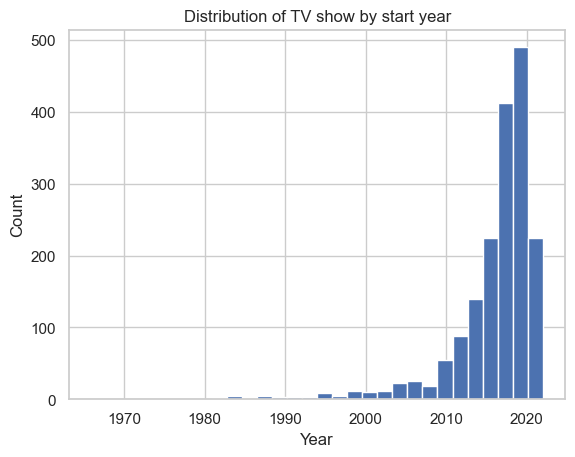

In [38]:
sns.histplot(shows_df["start_year"], bins=30, alpha=1)
plt.xlabel("Year")
plt.title("Distribution of TV show by start year")

Given that most shows in the dataset started within the last decade, it is more appropriate to focus on exploring general characteristics such genres or ratings rather than trends over time. Since television is a medium that changes over time, we should also keep in mind that any insights we uncover here are likely to only reflect recent television and may not be true for older television shows.

Briefly examine end year for completeness:

In [7]:
shows_df["end_year"].describe()

count         1226.0
mean     2017.946982
std         5.010483
min           1969.0
25%           2017.0
50%           2019.0
75%           2020.0
max           2025.0
Name: end_year, dtype: Float64

The end year is intentionally missing some values, but shows a similar pattern to start year but shifted slightly forwards. This makes sense because a show has to start before it ends.

#### Show statuses

In [8]:
shows_df["status"].value_counts()

status
Ended               1208
Running              412
To Be Determined     149
Name: count, dtype: int64

A large majority of the shows have ended. This is not surprising given the data was collected around 4 years ago.

How long does a show typically run?

In [9]:
duration_df = shows_df[shows_df["status"] == "Ended"].copy()
duration_df["duration"] = duration_df["end_year"] - duration_df["start_year"]
duration_df["duration"].describe()

count      1208.0
mean     2.404801
std      3.215674
min           0.0
25%           0.0
50%           1.0
75%           3.0
max          37.0
Name: duration, dtype: Float64

The median duration is 1 year and the average duration is about 2 years and 5 months.

The newest shows in the dataset started in 2022, so any still running as of 2025 have already had a longer than expected duration. Therefore, the values for status are to be expected.

#### Languages

In [10]:
shows_df["language"].value_counts()

language
English          837
Japanese         148
Spanish           76
Korean            68
Chinese           31
French            28
Portuguese        24
Hindi             23
Thai              19
Turkish           15
German            14
Swedish           10
Italian           10
Polish            10
Arabic             7
Danish             6
Hebrew             6
Dutch              5
Norwegian          5
Russian            4
Tagalog            4
Icelandic          3
Finnish            2
Catalan            2
Malay              2
Luxembourgish      1
Galician           1
Tamil              1
Hungarian          1
Name: count, dtype: int64

Most shows in the dataset are in English, with a sizeable minority in Japanese, Spanish and Korean. Other languages are represented, but not enough to be notable. This means that the shows are drawn from a wide geographical area.

#### Genres
What are the prevalent genres in the dataset?

Examine the top 10:

In [11]:
top_genre_query = """
    SELECT genre, COUNT(show_id) AS titles
    FROM genres
    JOIN shows_genres
    ON genres.id = shows_genres.genre_id
    GROUP BY 1
    ORDER BY 2 DESC
    LIMIT 10;
"""

In [12]:
top_genre_df = pd.read_sql_query(top_genre_query, engine)
top_genre_df

,genre,titles
0,Drama,721
1,Comedy,510
2,Animation,451
3,Action,349
4,Adventure,285
5,Crime,255
6,Documentary,168
7,Romance,165
8,Reality-TV,162
9,Mystery,136


<Axes: title={'center': 'Top 10 genres by number of series'}, xlabel='genre'>

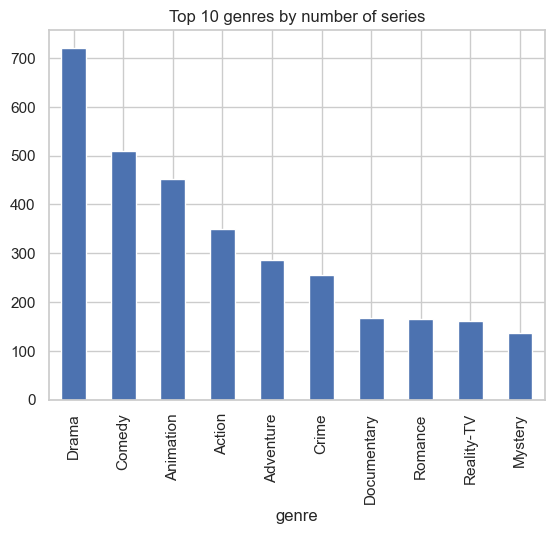

In [13]:
top_genre_df.plot.bar(x="genre", title="Top 10 genres by number of series", legend=False)

**Note**: Each TV show can have multiple genres.

The chart shows that the most common genre by far is *Drama*.  There is also a drop off after *Crime* (ranked number 6). For future analysis, we will concentrate on the six biggest genres.

#### Other summary statistics

In [14]:
shows_df[["run_time", "votes"]].describe().round(2)

,run_time,votes
count,1593.00,1619.0
mean,38.65,24467.0
std,17.92,83999.3
min,1.00,6.0
25%,24.00,356.5
50%,37.00,1495.0
75%,50.00,10061.5
max,210.00,1552311.0


Checking the remaining columns, we can see that a typical episode runs between 24 and 50 minutes, but with some as short a 1 minute and others as long as 210 minutes.

The votes column is how many users have rated a show on IMDb. This column has a wide range of values with a show typically having anywhere between 357 and 10062 votes. There also tends to be a smaller number of very popular shows that have received many votes.

#### Dataset characteristics
In summary, the dataset contains information about a large number of television shows with the majority beginning in the last decade and have already concluded by 2025. About half of these shows are in English, with notable representation from Japanese, Spanish and Korean reflecting the international scope of modern television.

Multiple genres are also present. Drama stands out as the most common, followed by comedy, animation, action, and crime. Many shows are associated with multiple genres indicating the diverse narratives in storytelling.

### Ratings
Ratings for the shows come from two different sources, TVMaze and IMDb. Both websites use the same scale for ratings.

Examine the distributions of both columns:

In [15]:
shows_df[["rating_tvmaze", "rating_imdb"]].describe()

,rating_tvmaze,rating_imdb
count,850.000000,1619.000000
mean,7.048118,7.142001
std,0.982258,1.112577
min,2.000000,1.100000
25%,6.500000,6.600000
50%,7.300000,7.300000
75%,7.800000,8.000000
max,9.200000,9.400000


The users on both sites appear to have similar opinions. Most shows are rated around 7 out of 10 with TVMaze being slightly more negative. The range and standard deviation for TVMaze are also a little smaller representing more consistent ratings across the dataset.

However, the sample sizes change drastically between the two. There are only 850 ratings from TVMaze but IMDb has 1619, almost double. Before drawing any conclusions, we need to examine only the shows that have been rated on both websites:

In [16]:
ratings_query = """
    SELECT id, title, rating_tvmaze, rating_imdb
    FROM shows
    WHERE rating_tvmaze IS NOT NULL AND rating_imdb IS NOT NULL;
"""
ratings_df = pd.read_sql_query(ratings_query, engine)

In [17]:
ratings_df[["rating_tvmaze", "rating_imdb"]].describe()

,rating_tvmaze,rating_imdb
count,810.000000,810.000000
mean,7.066790,7.416173
std,0.975064,0.923741
min,2.000000,3.300000
25%,6.500000,6.900000
50%,7.300000,7.500000
75%,7.800000,8.100000
max,9.200000,9.400000


Considering only the shows rated by both, we can see that TVMaze is more negative than IMDb.

Is this difference statistically significant?

In [18]:
t_stat, p_value = ttest_rel(ratings_df["rating_tvmaze"], ratings_df["rating_imdb"])
print(f"The t-statistic is {round(t_stat, 2)} and the p-value is {round(p_value, 3)}.")

The t-statistic is -12.17 and the p-value is 0.0.


The t-test demonstrates that the TVMaze rates shows more negatively, and that the difference is significant.

Visualise and compare the two distributions with a boxplot:

Text(0.5, 1.0, 'Boxplots of rating: TVMaze and IMDb')

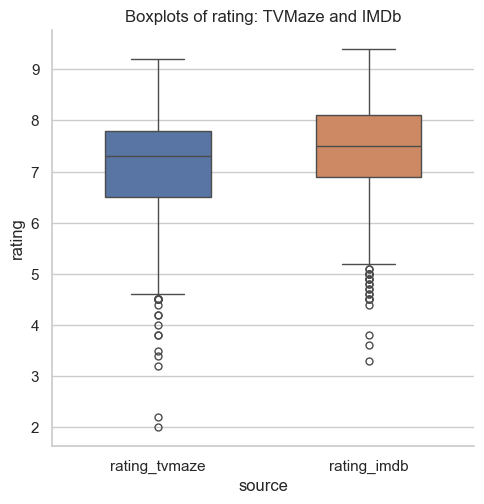

In [19]:
ratings_long = pd.melt(ratings_df, id_vars=["id", "title"], var_name=["source"], value_name="rating")
sns.catplot(data=ratings_long, kind="box", x="source", y="rating", hue="source", width=0.5)
plt.title("Boxplots of rating: TVMaze and IMDb")

The distributions are easier to see as boxplots. The interquartile range for both sites are roughly equal, but the box for IMDb is shifted up. The range of opinions are similar for both sets, but TVMaze has a slightly wider range suggesting broader user sentiment.

What is the cause of this difference? Do the users of the different sites disagree about which shows are good or bad?

In [20]:
round(ratings_df["rating_tvmaze"].corr(ratings_df["rating_imdb"]), 2)

0.63

The Pearson correlation between the TVMaze and IMDb ratings is 0.63. This indicates a moderately positive relationship. Users of both sites broadly agree on which shows they enjoy, but there may be differences in how they rated specific titles.

We can analyse by genre to try to uncover patterns in how shows are rated.

#### Rating by genre
We know that TVMaze users are more negative in their assessment of TV shows, but are there some genres that they prefer?

In [21]:
# Select data from the 6 most common genres:
ratings_genre_query = """
    SELECT rating_tvmaze, rating_imdb, genre
    FROM shows
    JOIN shows_genres
    ON shows.id = shows_genres.show_id
    JOIN genres
    ON shows_genres.genre_id = genres.id
    WHERE rating_tvmaze IS NOT NULL
        AND rating_imdb IS NOT NULL
        AND genre IN ('Drama', 'Comedy', 'Animation', 'Action', 'Adventure', 'Crime');
"""

In [22]:
ratings_genres = pd.read_sql_query(ratings_genre_query, engine)

In [23]:
comparisons_df = ratings_genres.groupby("genre").agg({
    "rating_tvmaze": "mean",
    "rating_imdb": "mean"})
comparisons_df["rating_tvmaze"] = round(comparisons_df["rating_tvmaze"], 2)
comparisons_df["rating_imdb"] = round(comparisons_df["rating_imdb"], 2)
comparisons_df["difference"] = comparisons_df["rating_tvmaze"] - comparisons_df["rating_imdb"]
comparisons_df

,rating_tvmaze,rating_imdb,difference
genre,,,
Action,7.16,7.35,-0.19
Adventure,7.10,7.31,-0.21
Animation,6.84,7.30,-0.46
Comedy,7.01,7.43,-0.42
Crime,7.38,7.67,-0.29
Drama,7.31,7.55,-0.24


From the table above, we can see that TVMaze users' average ratings are invariably worse than IMDb users' across all six genres. However, the preference for genres is fairly consistent  with *Crime* being the most liked and *Animation* being the least liked among both sets of users.

We can also see that the ratings of *Action* and *Adventure* vary the least between the two sites, while the ratings of *Animation* and *Comedy* vary the most.

In [24]:
ratings_genres = ratings_genres.rename({"rating_tvmaze": "tvmaze", "rating_imdb": "imdb"}, axis=1)
ratings_genre_long = pd.melt(ratings_genres, id_vars=["genre"], var_name=["source"], value_name="rating")

Visualise the ratings below with the error bars representing the standard deviation:

Text(0.5, 1.0, 'Genres by average rating: TVMaze and IMDb')

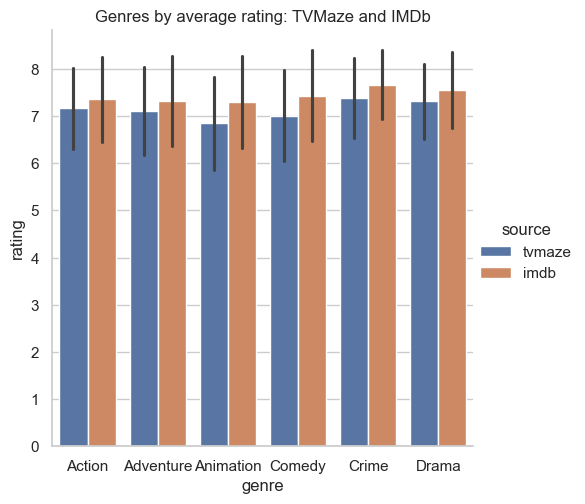

In [25]:
sns.catplot(data=ratings_genre_long,
            kind="bar",
            x="genre",
            y="rating",
            hue="source",
            dodge="true",
            errorbar="sd",
            order=["Action", "Adventure", "Animation", "Comedy", "Crime", "Drama"])
plt.title("Genres by average rating: TVMaze and IMDb")

From the chart, we can see the ratings from each site are similar across all genres.

It is important to note that the comparison is not just between two sites, but also between two points in time. The original IMDb ratings were collected in 2021 while the TVMaze ratings reflect user opinion as of 2025. The lower ratings on TVMaze may be due the natural decline in enthusiasm for individual shows rather than a more critical userbase. To confirm this hypothesis, we would need to compare the TVMaze ratings with up-to-date IMDb ratings.

### Popular show trends
To explore how television shows within a genre overlap over time, we can use Gantt charts to visualise the run periods of the five most popular shows in each genre. A high degree of overlap could be an indicator of a saturated genre, while a more staggered timeline may indicate less competition.

But how do we measure the popularity of a show?

While the dataset does not provide the number of viewers a given show has had, we can use the number of votes as a proxy for popularity - more votes likely indicates more viewers. However, can we also define a popular show as one with a high rating?

Check if popularity (number of votes) is correlated with rating:

In [26]:
votes_rating_corr = shows_df["rating_imdb"].corr(shows_df["votes"])
round(votes_rating_corr, 2)

0.27

In the dataset, there is only a weak correlation (0.27) between votes and ratings. The most well known shows are not necessarily the most well liked. This highlights the distinction between reach and reception. A show may be mediocre and widely viewed, or well received but only by a small, dedicted audience. Therefore we will define a popular show as one that has received a lot of votes.

Load the result of the SQL query into a dataframe:

In [27]:
show_genre_query = """
    SELECT title, start_year, end_year, votes, genre, status
    FROM shows
    JOIN shows_genres
    ON shows.id = shows_genres.show_id
    JOIN genres
    ON shows_genres.genre_id = genres.id
"""
show_genre_df = pd.read_sql_query(show_genre_query, engine, dtype={"start_year":"Int64", "end_year":"Int64"})


Work out the duration of each show. Change end year to the current year for ongoing shows:

In [28]:
show_genre_df["end_year"] = show_genre_df["end_year"].fillna(datetime.now().year)
show_genre_df["duration"] = show_genre_df["end_year"] - show_genre_df["start_year"]
show_genre_df = show_genre_df.sort_values(by="votes", ascending=False).reset_index(drop=True)

Function to subset the dataframe to the top 5 most popular shows:

In [29]:
def genre_df_creation(a_genre):
    gantt_genre_df = show_genre_df[show_genre_df["genre"] == a_genre]
    gantt_genre_df = gantt_genre_df.iloc[0:5, :].sort_values("start_year")
    return gantt_genre_df

Demonstrate the Gantt chart with the two most common genres:

In [30]:
genre_list = ["Drama", "Comedy"]

gantt_df_1 = genre_df_creation(genre_list[0])
gantt_df_2 = genre_df_creation(genre_list[1])

Text(0.5, 1.0, 'Top TV Show durations: Drama and Comedy')

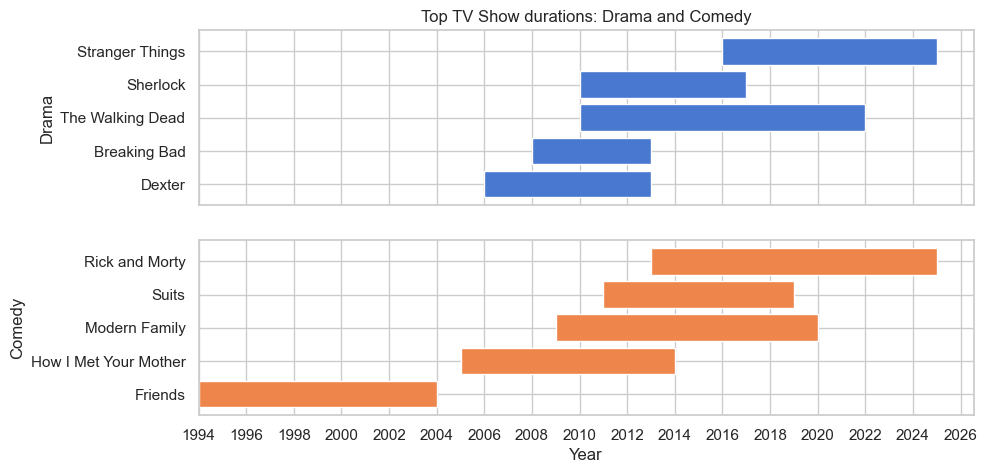

In [31]:
fig, ax = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
ax[0].barh(gantt_df_1["title"], gantt_df_1["duration"], left=gantt_df_1["start_year"], color=palette[0])
ax[1].barh(gantt_df_2["title"], gantt_df_2["duration"], left=gantt_df_2["start_year"], color=palette[1])
ax[0].xaxis.set_major_locator(MultipleLocator(2))
ax[1].set_xlabel("Year")
ax[0].set_ylabel(genre_list[0])
ax[1].set_ylabel(genre_list[1])
ax[0].set_title(f"Top TV Show durations: {genre_list[0]} and {genre_list[1]}")

The Gantt charts shows the durations of the five most popular shows in the Drama and Comedy genres. From this subset, we can see that dramas tend to have shorter, overlapping runs. Comedies on the other hand, have longer runs with several airing simultaneously during the early 2010s. The overlapping periods may suggest higher market saturation within each genre.

However, this chart should be interpreted with caution. The apparent market saturation may simply reflect the bias towards newer shows present in the dataset. Additionally, genre labels, particularly the more common ones, can be vague and overlapping, making it difficult to draw solid conclusions based on genre alone.

### Genre co-occurrence

In this section, we will look at the tendency of genres to appear together. As shown earlier, an individual show may belong to multiple different genres, and some combinations are more common than others. By examining genre co-occurrence, we can identify which genres frequently overlap, and which genres tend to stand alone.

To improve the clarity of the visual, we will only examine genres which have more than 100 shows:

In [32]:
top_genres = show_genre_df["genre"].value_counts()
top_genres = list(top_genres[top_genres > 100].index)
filtered_genres = show_genre_df[show_genre_df["genre"].isin(top_genres)]

Using crosstab, mark which shows belong to which genres. Shows are the rows and genres are the columns, if a show has that genre, the cell contains 1 otherwise 0.

In [33]:
genre_matrix = pd.crosstab(filtered_genres["title"], filtered_genres["genre"])

Multiple the transposed version of this matrix with the matrix itself to sum up how many shows have both genres:

In [34]:
co_occurrence = genre_matrix.T @ genre_matrix

To account for differences in the number of titles, we can normalise the matrix to get the proportion of titles that share a genre rather than the absolute number.

Divide the matrix by the diagonal:

In [35]:
normalised = co_occurrence.div(np.diag(co_occurrence), axis=0)
normalised = normalised.round(2)

Text(0.5, 1.0, 'Genre co-occurence matrix')

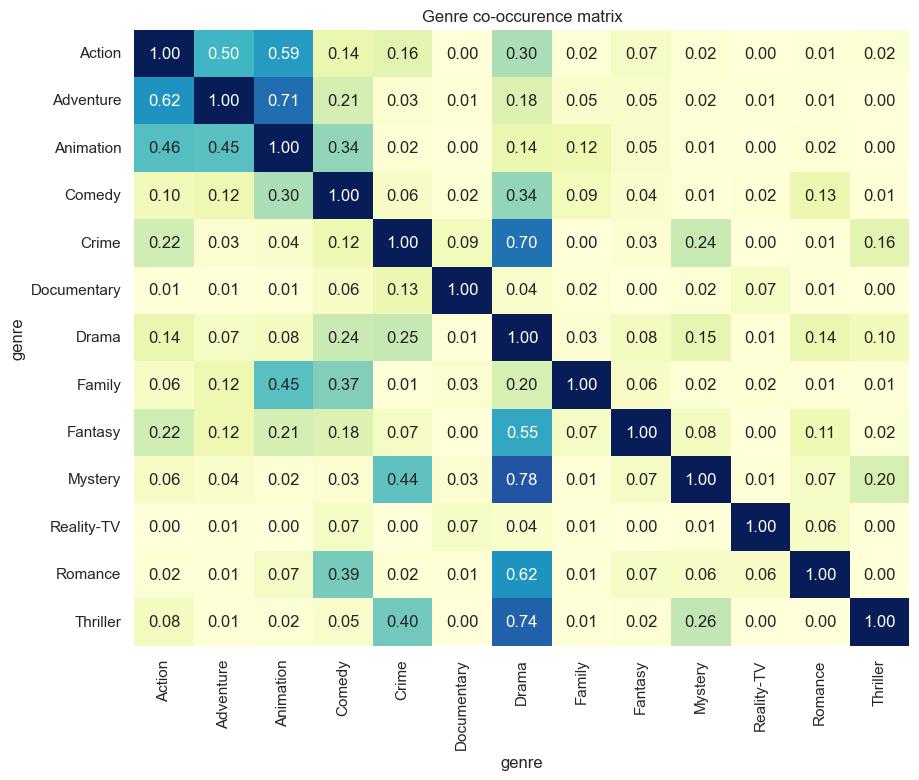

In [36]:
plt.figure(figsize=(10, 8))
sns.heatmap(normalised, cmap="YlGnBu", annot=True, fmt=".2f", cbar=False)
plt.title("Genre co-occurence matrix")

The heatmap shows how often pairs of genres appear together in the same show. Each row and column represents a genre, and the values in the cells indicate the proportion of shows in the row genre that also include the column genre.

The diagonal values are all equal to 1.00 simply reflecting that each genre is present with itself. These values represent the trivial case and are not informative but are included for completeness.

It is also important to note that the heatmap is not symmetrical. Two pairs of genres may have a two way relationship depending on the frequency each appear in the dataset. For example, *Drama* is a co-occuring genre in 74% of *Thriller* shows, but *Thriller* only appears as a genre in 10% of *Drama* shows. This can be explained by the relative frequency of each genre with *Drama* being much more common.

In addition to being informative about co-occurrences, the heatmap is also useful for identifying redundant or overly vague genres. Strong co-occurence, especially if it is imbalanced, suggests that some labels carry overlapping information. If we were to construct a classifier that predicts genre based on the summary, the highly redundant labels, such as *Drama*, may be removed while keeping the informative labels such as *Reality-TV*. 

### Summary
In the final part of this project, we analysed some key characteristics of the dataset. We started by examining the shows over time, and found that there is a strong bias towards recent years. Next, we looked at genre distribution and identified the six most common genres. Ratings between the two platforms were also explored. We found that the two platforms were correlated, but TVMaze was significantly more negative than IMDb, possibly due to user sentiment or simply temporal difference.

Gantt charts were used to visualise the air periods of the most popular shows in the two most common genres. Finally, we used a heatmap to identify which pairs of genres frequently appeared in the same show. This insight may be useful when trying to classify genre based on description.

#### Limitations
While the main focus of the project was on the process of cleaning and normalisation, some valuable insights were still found in the data. However, the final dataset has some limitations. It is important to remember that the original data was scraped in 2021, and as such was out-dated by the time the project started. For a more comprehesive analysis, IMDb provides <a href="https://developer.imdb.com/non-commercial-datasets/">official datasets</a> which may be appropriate for future projects.

The same analysis is provided as a Streamlit dashboard <a href="https://television-series-dashboard.streamlit.app/">here</a>.

### Navigation

**Previous book**: <a href='./05_normalisation.ipynb'>[Normalisation]</a>

**Next book**: None